In [1]:
"""

f(R) gravity emulator: for fast generation of P_mg/P_lcdm


Requires the following installations:

1. R (R studio is the easiest option: https://www.rstudio.com/products/rstudio/download/).
Installing R packages is easy, in R studio, command install.packages("package_name") works
(https://www.dummies.com/programming/r/how-to-install-load-and-unload-packages-in-r/)
The following R packages are required:
    1a. RcppCNPy
    1b. DiceKriging
    1c. GPareto

2. rpy2 -- which runs R under the hood (pip install rpy2 should work)
# http://rpy.sourceforge.net/rpy2/doc-2.1/html/index.html
# conda install -c r rpy2

Built by N. Ramachandra and M. Binois 
"""

##### Generic packages ###############
import numpy as np
import matplotlib.pylab as plt
import time
import glob
import os


"""
GP emulation
"""
##### Packages ###############

import pickle
from sklearn.decomposition import PCA
import GPy


####### PLOTTING SETTINGS #####
from itertools import cycle
import matplotlib.ticker as ticker
from matplotlib import gridspec


plt.rc('text', usetex=True)  # Slower
plt.rc('axes',labelsize= 10)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


########## R imports ############
# RcppCNPy = importr('RcppCNPy')
# RcppCNPy.chooseCRANmirror(ind=1) # select the first mirror in the list
## There are other importr calls in PCA and GP functions


In [20]:
############################# PARAMETERS ##############################
nRankMax = 4 ## Number of basis vectors in truncated PCA
del_idx =  [5, 25, 4, 42]  ## holdouts for testing
snap_ID = 97
############################# INPUT FILES ##############################

plotsDir = "./Plots/" ## Data folder
# dataDir = "./Data/Emulator_data/" ## Data folder
dataDir = "./Data/Emulator213bins/" ## Data folder

paramIn = dataDir + 'mg.design'  ## parameter file



az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbins_' + str(snap_ID) + '.txt'
GPmodel = '"GP_model_213Smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID) +'.RData"'  ## Double and single quotes are necessary
## DELETE the GPmodels or provide a new name if you want a new calculation
# num_holdout = 4
print(GPmodel)
################################# I/O #################################


loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
parameter_array_all = np.loadtxt(paramIn)
z_ID = az[snap_ID, 1]

########################## Deleting hold-out from training ##############


PmPl = np.delete(PmPl_all, del_idx, axis = 0)
parameter_array = np.delete(parameter_array_all, del_idx, axis = 0)


####################### porting to R backend #######################

#### adding smoothing filter ########

import scipy.signal
yhat = scipy.signal.savgol_filter(PmPl[:,:], 51, 3) # window size 51, polynomial order 3

####################################



nr, nc = yhat.shape
y_train = ro.r.matrix(yhat, nrow=nr, ncol=nc)


# nr, nc = PmPl[:,:].shape
# y_train = ro.r.matrix(PmPl[:,:], nrow=nr, ncol=nc)
ro.r.assign("y_train2", y_train)
r('dim(y_train2)')

nr, nc = parameter_array[:,:].shape
u_train = ro.r.matrix(parameter_array[:,:], nrow=nr, ncol=nc)
ro.r.assign("u_train2", u_train)
r('dim(u_train2)')

"GP_model_213Smooth_rank4snap97.RData"


46,5


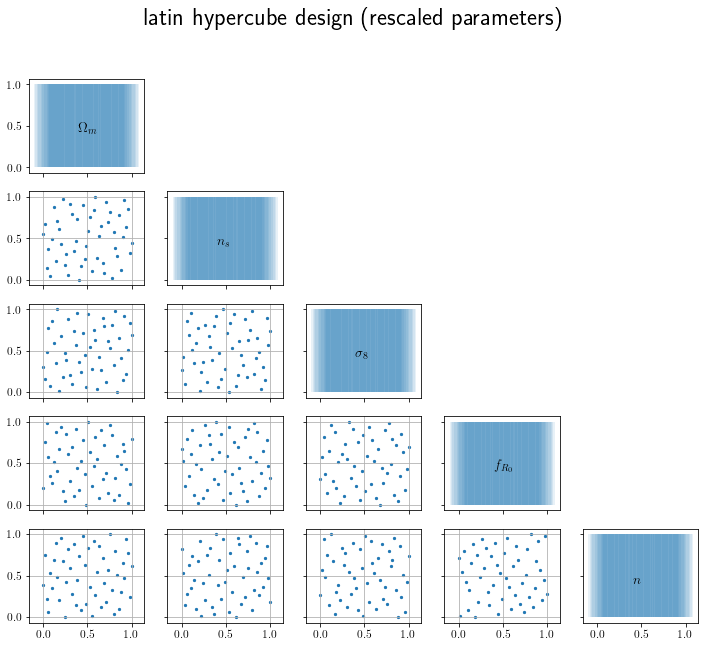

In [21]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']

def rescale01(f):
    return (f - np.min(f)) / (np.max(f) - np.min(f))

lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(12, 10) )
    plt.suptitle('latin hypercube design (rescaled parameters)', fontsize = 24)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
                
#             if (j > i):
                
                
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)

    for i in range(lhd.shape[1]):
        for j in range(i + 1, lhd.shape[1]):

            plt.delaxes(a[i][j])
    plt.show()


plot_params(lhd)

In [22]:
########################### PCA ###################################
def PCA_decomp():
#     Dicekriging = importr('DiceKriging')
    r('require(foreach)')
    ro.r.assign("nrankmax", nRankMax)
    r('svd(y_train2)')
    r('svd_decomp2 <- svd(y_train2)')
    r('svd_weights2 <- svd_decomp2$u[, 1:nrankmax] %*% diag(svd_decomp2$d[1:nrankmax])')


In [23]:
# r('install.packages("DiceKriging")')
Dicekriging = importr('DiceKriging')
Dicekriging = importr('emoa')
GPareto = importr('GPareto')
# r('remove.packages("GPareto")')
# r('install.packages("GPareto")')

# r('install.packages("GPareto", dependencies=TRUE, repos="https://cloud.r-project.org")')

# r('install.packages("DiceDesign")')
# r('install.packages("pbivnorm")')
# r('install.packages("rgenoud")')
# r('install.packages("rgenoud")')

R[write to console]: Error in loadNamespace(name) : there is no package called ‘GPareto’
Calls: <Anonymous> ... loadNamespace -> withRestarts -> withOneRestart -> doWithOneRestart



RRuntimeError: Error in loadNamespace(name) : there is no package called ‘GPareto’
Calls: <Anonymous> ... loadNamespace -> withRestarts -> withOneRestart -> doWithOneRestart


In [ ]:
######################## GP PREDICTION ###############################

def GP_model_load(GPmodel):
    GPareto = importr('GPareto')

    ro.r('''

    GPmodel <- gsub("to", "",''' + GPmodel + ''')

    ''')

    r('''if(file.exists(GPmodel)){
            load(GPmodel)
        }else{
            print("ERROR: No trained GP file")
         }''')
    print('Loaded: ', GPmodel)
    
    
def GP_predict(para_array):
    GPareto = importr('GPareto')


    para_array = np.expand_dims(para_array, axis=0)
    nr, nc = para_array.shape
    Br = ro.r.matrix(para_array, nrow=nr, ncol=nc)

    ro.r.assign("Br", Br)
#     r('print("loaded model in R kernel: ")')
#     r('print(GPmodel)')

    r('wtestsvd2 <- predict_kms(models_svd2, newdata = Br , type = "UK")')
    r('reconst_s2 <- t(wtestsvd2$mean) %*% t(svd_decomp2$v[,1:nrankmax])')

    y_recon = np.array(r('reconst_s2'))

    return y_recon[0]

In [ ]:
#################### PCA DECOMPOSITION DONE AGAIN ##############
# Dicekriging = importr('DiceKriging')

PCA_decomp()

#################### LOADING TRAINED GP MODEL ##############

GP_model_load(GPmodel)

In [ ]:
print(GPmodel)

In [ ]:
##################################### TESTING ##################################
plt.rc('font', size=18)  # 

PlotPrior = True

if PlotPrior:

    plt.figure(999, figsize=(14, 12))

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$',  fontsize = 18)

    ax1.set_xlabel(r'$k$[h/Mpc]',  fontsize = 18)
    ax1.axhline(y=0, ls='dashed')


    ax0.set_yscale('log')
    ax0.set_xscale('log')
    ax1.set_xscale('log')

    ax1.set_ylabel(r'emu/test - 1',  fontsize = 18)
    ax1.set_ylim(-5e-2, 5e-2)

    ax0.plot(kvals, PmPl_all.T, alpha=0.15, color='k')

    start, end = ax0.get_ylim()
    ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
    ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))


    ax0.set_xlim(kvals[0], kvals[-1])
    ax1.set_xlim(kvals[0], kvals[-1])
    ax0.set_xticklabels([])


    color_id = 0
    for x_id in del_idx[1:]:
        color_id = color_id + 1

        time0 = time.time()
        x_decodedGPy = GP_predict(parameter_array_all[x_id])  ## input parameters
        time1 = time.time()
        print('Time per emulation %0.3f' % (time1 - time0), ' s')
        x_test = PmPl_all[x_id]

        ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=plt.cm.Set1(color_id))
        ax0.plot(kvals, x_test, alpha=0.7, label='test', color=plt.cm.Set1(color_id))

        ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=plt.cm.Set1(color_id))

ax0.text(0.07, 1.4, 'z = %0.2f'%z_ID, fontsize= 18, style='italic')

plt.savefig(plotsDir + "Emu.png",  bbox_inches="tight", dpi=200)

plt.show()

In [ ]:
x_decodedGPy.shape

In [ ]:
PlotCls = True

if PlotCls:
    
    numPlots = 5

    fig, ax = plt.subplots(5,2, figsize = (15,26))
    plt.subplots_adjust(wspace=0.25)
    
    allMax = np.max(parameter_array, axis = 0)
    allMin = np.min(parameter_array, axis = 0)
    allMean = np.mean(parameter_array, axis = 0)
    Pk_mean = GP_predict(allMean) 
    
    for paramNo in range(5):
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  
            x_decodedGPy = GP_predict(para_plot) 
            lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])

            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()

            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')

            ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


        start, end = ax[4-paramNo, 0].get_ylim()
        ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
        ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity.png",  bbox_inches="tight", dpi=200)

plt.show()

In [ ]:
######### CALLING THE EMULATOR ##############
#### input arguments: (Om, ns, s8, fR0, n)
#### output: P_mg/P_lcdm in 20 bins
#### Example: 

GP_predict([0.1, 1.0, 0.8, 3e-5, 1.5])

In [ ]:

#################################################################################################
#################################################################################################
############################################## MCMC #############################################
#################################################################################################

import emcee
import pygtc

#### parameters that define the MCMC

ndim = 5
nwalkers = 600 #600  # 500
nrun_burn = 100  # 50 # 50  # 300
nrun = 700 #700  # 300  # 700


In [ ]:
#### FAKE DATA GENERATION #####


create_fake_fiducial = False

if create_fake_fiducial:
    dirDataIn = "./Data/FiducialData/"

    seed = 1
    np.random.seed(seed)

    Pk_ratio = np.loadtxt(dirDataIn + 'ratios213.txt')[:, 25].T
    Pk_ratio = (1 + np.random.rand()/100)*Pk_ratio
    np.savetxt(dirDataIn + 'fiducial_ratio213.txt', Pk_ratio)

    cov_mat = np.zeros(shape = (Pk_ratio.shape[0], Pk_ratio.shape[0]))

    for i in range(Pk_ratio.shape[0]):
        cov_mat[i, i] = (1 + kvals[i]**2)*(1 + np.random.rand())*np.sqrt(Pk_ratio[i])/8000

    np.savetxt(dirDataIn + 'fiducial_cov213.txt', cov_mat)

In [ ]:
# #### INTERPOLATED COV MATRIX GENERATION #####


create_cov_interpolate = True

if create_cov_interpolate:
    
    ### We have cavariance matrix for 20 bins, convert that to 213
        
    dirDataIn20 = "./Data/FiducialData/FromSims/"
    Pk_ratio20 = np.loadtxt(dirDataIn20 + 'ratioavg_97.txt')
    cov_mat20 = np.loadtxt(dirDataIn20 + 'covariance_97.txt')


    from scipy import interpolate 

    dataDir20 = "./Data/Emulator_data/" ## Data folder
    fileIn20 = dataDir20 + 'ratios_' + str(snap_ID) + '.txt'


    loadFile20 = np.loadtxt(fileIn20)
    kvals20 = loadFile20[:,0]

    x = kvals20
    y = kvals20
    z = cov_mat20

    cov_mat_model = interpolate.interp2d(x, y, z, kind='cubic')

    xnew = kvals
    ynew = kvals

    cov_mat213 = cov_mat_model(xnew, ynew)
    
    cov_mat = cov_mat213
    

    Pk_ratio_model = interpolate.CubicSpline(kvals20, Pk_ratio20[:, 1])
    
    Pk_ratio213 = Pk_ratio_model(kvals)
    
    Pk_ratio = Pk_ratio213
    
    

In [ ]:
plt.figure(232)

plt.plot(kvals, Pk_ratio213, 'x')
plt.plot(kvals20, Pk_ratio20[:, 1], 'o')


plt.show()

In [ ]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# %matplotlib notebook


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = kvals
Y = kvals
X, Y = np.meshgrid(X, Y)
Z = cov_mat

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis,
                       linewidth=0, antialiased=False, alpha = 0.2)



# Make data.
X = kvals20
Y = kvals20
X, Y = np.meshgrid(X, Y)
Z = cov_mat20

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno,
                       linewidth=0, antialiased=False, alpha = 0.4)






# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.8, aspect=5)

plt.show()

In [ ]:
kvals

In [ ]:
########## REAL DATA with ERRORS #############################

# Pk_ratio = np.loadtxt(dirDataIn + 'fiducial_ratio213.txt')
# cov_mat = np.loadtxt(dirDataIn + 'fiducial_cov213.txt')

# dirDataIn = "./Data/FiducialData/FromSims/"
# Pk_ratio = np.loadtxt(dirDataIn + 'ratioavg_97.txt')
# cov_mat = np.loadtxt(dirDataIn + 'covariance_97.txt')

# kvals_max = 3.2
# kvals_cond = np.where(Pk_ratio < kvals_max)
kvals_cond = True

x = np.array(kvals)
y = Pk_ratio
yerr_diag = np.sqrt(np.diag(cov_mat))#[:, 0]



# x = x[kvals_cond]
# y = y[kvals_cond]

yerr_diag = yerr_diag[kvals_cond][0]
# emax = emax[ls_cond][:,ls_cond][:,0,:]
# cov_mat =  cov_mat[:len(kvals_cond[0]), :len(kvals_cond[0])]
## Only works if slicing is done at a corner.
# i.e., if ls_cond corresponds to continuous array entries in l
# icov = np.linalg.inv(cov_mat)


icov = np.linalg.pinv(cov_mat)

# Moore-Penrose pseudo-inverse of a matrix.



In [ ]:
# Pk_ratio

In [ ]:
plt.figure(34, figsize = (8, 6))
# np.sqrt(yerr[::5])/Cl[::5]
plt.errorbar(x[::], y[::], yerr= yerr_diag[::] , marker='o',
       color='k',
       ecolor='k',
       markerfacecolor='g',
       markersize = 2,
       capsize=0,
       linestyle='None')


# plt.plot(kvals, np.loadtxt(dirDataIn + 'ratios213.txt')[:, 1:], alpha = 0.3)
plt.plot(kvals, Pk_ratio, alpha = 0.3)
# plt.xscale('log')
# plt.show()

plt.savefig('Plots/PowerSpect_emu.pdf')


plt.figure(43, figsize = (7, 6))
plt.imshow(cov_mat)
plt.colorbar()
# plt.show()

plt.savefig('Plots/Cov_mat.pdf')


In [ ]:
y.shape

In [ ]:
kvals.shape

In [ ]:

# #### Cosmological Parameters ########################################

# parameter_array_all.min(axis=0)

# para1 = [allLabels[0], 0.1188, 0.12, 0.155]  # Actual 0.119
# para2 = [allLabels[1], 0.02230, 0.0215, 0.0235]
# para3 = [allLabels[2], 0.8159, 0.7, 0.89]
# para4 = [allLabels[3], 0.6774, 0.55, 0.85]
# para5 = [allLabels[4], 0.9667, 0.85, 1.05]


In [ ]:

#### Cosmological Parameters ########################################

allMin = parameter_array_all.min(axis=0)
allMax = parameter_array_all.max(axis=0)
# allMean = parameter_array_all.mean(axis=0)
# allMean = parameter_array_all[25]

allMean = [0.141745, 0.9667, 0.8159, 1e-5, 1.0]


# Ω_m*h^2=0.141745, n_s=0.9667, σ_8 = 0.8159 and for the MG part f_r0=10^-5 and n=1

para1 = [allLabels[0], allMean[0], allMin[0], allMax[0]]  # Actual 0.119
para2 = [allLabels[1], allMean[1], allMin[1], allMax[1]]
para3 = [allLabels[2], allMean[2], allMin[2], allMax[2]]
para4 = [allLabels[3], allMean[3], allMin[3], allMax[3]]
para5 = [allLabels[4], allMean[4], allMin[4], allMax[4]]


In [ ]:
para4

In [ ]:
#################### CHAIN INITIALIZATION ##########################

## 2 options

Uniform_init = True
if Uniform_init:
    # Choice 1: chain uniformly distributed in the range of the parameters
    pos_min = np.array( [para1[2], para2[2], para3[2], para4[2], para5[2]] )
    pos_max = np.array( [para1[3], para2[3], para3[3], para4[3], para5[3]] )
    psize = pos_max - pos_min
    pos0 = [pos_min + psize * np.random.rand(ndim) for i in range(nwalkers)]

True_init = False
if True_init:
    # Choice 2: chain is initialized in a tight ball around the expected values
    pos1 = [[para1[1] * 1.2, para2[1] * 0.8, para3[1] * 0.9, para4[1] * 1.1, para5[1] * 1.2] +
            1e-3 * np.random.randn(ndim) for i in range(nwalkers)]

MaxLikelihood_init = False
if MaxLikelihood_init:
    # Choice 2b: Find expected values from max likelihood and use that for chain initialization
    # Requires likehood function below to run first

    import scipy.optimize as op

    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [para1[1], para2[1], para3[1], para4[1], para5[1]], args=(x, y, icov))
    p1_ml, p2_ml, p3_ml, p4_ml, p5_ml = result["x"]
    print(result['x'])

    pos0 = [result['x'] + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]


In [ ]:
np.array(pos0).shape

In [ ]:
# pygtc.plotGTC(pos)

In [ ]:
# Visualize the initialization

PriorPlot = False

if PriorPlot:
    fig = pygtc.plotGTC(pos0, labels=[para1[0], para2[0], para3[0], para4[0], para5[0]],
                        range=[[para1[2], para1[3]], [para2[2], para2[3]],
                               [para3[2], para3[3]],
                               [para4[2], para4[3]], [para5[2], para5[3]]],
                        truths=[para1[1], para2[1], para3[1], para4[1], para5[1]])
    fig.set_size_inches(10, 10)

######### not working #######################

In [ ]:
allMin

In [ ]:
allMax

In [ ]:
p1, p2, p3, p4, p5 = allMean

In [ ]:
if (para1[2] < p1 < para1[3] and para2[2] < p2 < para2[3] and para3[2] < p3 < para3[3] and para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        print('Success')
print('fail')

In [ ]:
def lnprior(theta):
    p1, p2, p3, p4, p5 = theta
    # if 0.12 < p1 < 0.155 and 0.7 < p2 < 0.9:
    if (para1[2] < p1 < para1[3] and para2[2] < p2 < para2[3] and para3[2] < p3 < para3[3] and para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        return 0.0
    return -np.inf


In [ ]:
def lnprior_gauss(theta):
    p1, p2, p3, p4, p5 = theta
    #flat priors on b, c
#     if not 1.0 < b < 2.0 and 1.0 < c < 2.0:
    if not (para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        return -np.inf
    #gaussian prior on a
    mu_para1 = para1[1]
    sigma_para1 = np.abs(para1[2] - para1[3])/6
#     lnprior1 =  np.log(1.0/(np.sqrt(2*np.pi)*sigma_para1))-0.5*(p1-mu_para1)**2/sigma_para1**2
    lnprior1 =  -0.5*(p1-mu_para1)**2/sigma_para1**2
    
        #gaussian prior on d
    mu_para2 = para2[1]
    sigma_para2 = np.abs(para2[2] - para2[3])/6
#     lnprior2 =  np.log(1.0/(np.sqrt(2*np.pi)*sigma_para2))-0.5*(p2-mu_para2)**2/sigma_para2**2
    lnprior2 =  -0.5*(p2-mu_para2)**2/sigma_para2**2
    
        #gaussian prior on e
    mu_para3 = para3[1]
    sigma_para3 = np.abs(para3[2] - para3[3])/6
#     lnprior3 =  np.log(1.0/(np.sqrt(2*np.pi)*sigma_para3))-0.5*(p3-mu_para3)**2/sigma_para3**2
    lnprior3 =  -0.5*(p3-mu_para3)**2/sigma_para3**2
    
    return (lnprior1 + lnprior2 + lnprior3)
    
    

In [ ]:
lnprior([0.1, 1.1, 0.8, 3e-5, 1.5])

In [ ]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike_diag(theta, x, y, yerr):
    p1, p2, p3, p4, p5 = theta

    new_params = np.array([p1, p2, p3, p4, p5])

    model = GP_predict(new_params)
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))
#     return -0.5 * (np.sum(((y - model) / yerr) ** 2.))


def lnlike(theta, x, y, icov):
    p1, p2, p3, p4, p5 = theta

    new_params = np.array([p1, p2, p3, p4, p5])

    model = GP_predict(new_params)
    
    y_model = np.asarray(y-model)
    icov = np.asarray(icov)
    return -0.5*(y_model.dot(icov).dot(y_model))

In [ ]:



# def lnprob(theta, x, y, yerr):
#     lp = lnprior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     # return lp + lnlike_diag(theta, x, y, yerr)
#     return lp + lnlike(theta, x, y, yerr)


def lnprob(theta, x, y, yerr):
    lp = lnprior_gauss(theta)
    if not np.isfinite(lp):
        return -np.inf
    # return lp + lnlike_diag(theta, x, y, yerr)
    return lp + lnlike(theta, x, y, yerr)
############################# PARAMETERS ##############################

In [ ]:

######### MCMC #######################


## Sample implementation :
# http://eso-python.github.io/ESOPythonTutorials/ESOPythonDemoDay8_MCMC_with_emcee.html
# https://users.obs.carnegiescience.edu/cburns/ipynbs/Emcee.html


# Let us setup the emcee Ensemble Sampler
# It is very simple: just one, self-explanatory line

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr_diag))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, icov))

###### BURIN-IN #################

time0 = time.time()
# burnin phase
pos, prob, state = sampler.run_mcmc(pos0, nrun_burn)
sampler.reset()
time1 = time.time()
print('burn-in time:', time1 - time0)

In [ ]:


###### MCMC ##################
time0 = time.time()
# perform MCMC
pos, prob, state = sampler.run_mcmc(pos, nrun)
time1 = time.time()
print('mcmc time:', time1 - time0)

samples = sampler.flatchain
samples.shape

###########################################################################

In [ ]:

###########################################################################
samples_plot = sampler.chain[:, :, :].reshape((-1, ndim))

np.savetxt('Data/Chains/SamplerPCA_mcmc_ndim' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
    nrun) + '.txt', sampler.chain[:, :, :].reshape((-1, ndim)))

####### FINAL PARAMETER ESTIMATES #######################################



In [ ]:

samples_plot = np.loadtxt('Data/Chains/SamplerPCA_mcmc_ndim' + str(ndim) + '_nwalk' + str(
    nwalkers) + '_run' + str(nrun) + '.txt')

# samples = np.exp(samples)
p1_mcmc, p2_mcmc, p3_mcmc, p4_mcmc, p5_mcmc = map(lambda v: (v[1], v[2] - v[1],
                                                                               v[1] - v[0]) , zip(*np.percentile(samples_plot, [16, 50, 84], axis=0)))
print('mcmc results:', p1_mcmc[0], p2_mcmc[0], p3_mcmc[0], p4_mcmc[0], p5_mcmc[0])


In [ ]:
samples_plot[:,:2].shape

In [ ]:
####### CORNER PLOT ESTIMATES #######################################

CornerPlot = True
if CornerPlot:

    fig = pygtc.plotGTC(samples_plot,
                        paramNames=[para1[0], para2[0], para3[0], para4[0], para5[0]],
                        truths=[para1[1], para2[1], para3[1], para4[1], para5[1]],
                        figureSize='MNRAS_page')  # , plotDensity = True, filledPlots = False,\smoothingKernel = 0, nContourLevels=3)

    fig.savefig('Plots/pygtcPCA_' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
        nrun) +  '.pdf')

####### FINAL PARAMETER ESTIMATES #######################################

In [ ]:
# import numpy
# lnlike([0.1, 1.1, 0.8, 3e-5, 1.5], x, y, yerr_diag)

In [ ]:
lnprior([0.1, 1.1, 0.8, 3e-5, 1.5])

In [ ]:
pos0[0]

In [ ]:
[para1[2], para2[2], para3[2], para4[2], para5[2]]


In [ ]:
samplerlnprob = (sampler.lnprobability)


In [ ]:
plt.figure(2323, figsize = (10,10))
plt.plot(samplerlnprob.T)
plt.yscale('symlog')

In [ ]:
plt.figure(23)
plt.hist(samplerlnprob[:, -1][samplerlnprob[:, -1] > -100], 20, alpha = 0.4)
plt.hist(samplerlnprob[:, -1][samplerlnprob[:, -1] > -30], 10, alpha = 0.4)

In [ ]:
####### CORNER PLOT ESTIMATES #######################################

new_samples = sampler.chain[samplerlnprob[:, -1] > -10][:, :, :].reshape((-1, ndim))


CornerPlot = True
if CornerPlot:

    fig = pygtc.plotGTC(samples_plot,
                        paramNames=[para1[0], para2[0], para3[0], para4[0], para5[0]],
                        truths=[para1[1], para2[1], para3[1], para4[1], para5[1]],
                        figureSize='MNRAS_page')  # , plotDensity = True, filledPlots = False,\smoothingKernel = 0, nContourLevels=3)

    fig.savefig('Plots/pygtcPCA_' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
        nrun) +  '.pdf')

####### FINAL PARAMETER ESTIMATES #######################################

In [ ]:
# tau = sampler.get_autocorr_time()
# autocorr[index] = np.mean(tau)

In [ ]:
import matplotlib.pyplot as plt

n = 100*np.arange(1, index+1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

In [ ]:
# Compute the estimators for a few different chain lengths
chain = sampler.chain#[:, :, 0].T


N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);